In [1]:
import os
import torch, torch.nn as nn
from torchsummary import summary
from torch_snippets import *
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using: {DEVICE}')

Using: cuda


# Data Inspection

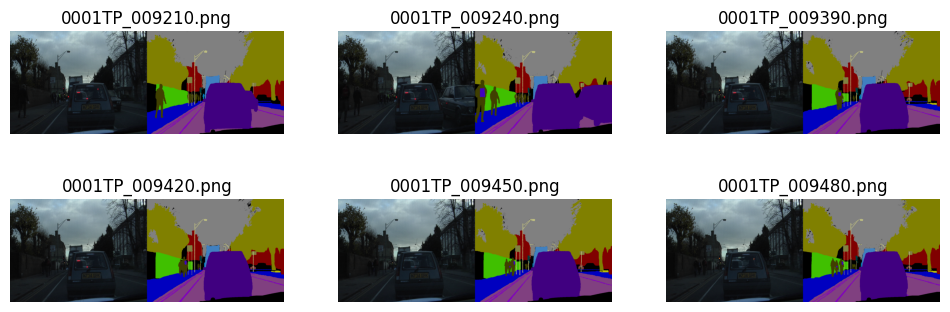

In [2]:
DATA_DIR = './CamVid/CamVid'

nrows, ncols = 2, 3
plt.figure(figsize=(ncols*4, nrows*2))

count = 0
for id in os.listdir(os.path.join(DATA_DIR, 'train')):
    if count == nrows * ncols:
        break
    count += 1
    img_path = os.path.join(DATA_DIR, 'train', id)
    mask_path = os.path.join(DATA_DIR, 'train_labels', id[:-4] + '_L.png')

    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('RGB')
    
    combined = np.hstack([img, mask])

    plt.subplot(nrows, ncols, count)
    plt.title(id)
    plt.axis('off')
    plt.imshow(combined)

In [3]:
# Check if some images are missing masks

splits = ['train', 'test', 'val']

for split in splits:
    images_dir = os.path.join(DATA_DIR, split)
    masks_dir = os.path.join(DATA_DIR, split + '_labels')

    print(f'Number of images in {split} subset: {len(os.listdir(images_dir))}')
    print(f'Number of masks in {split} subset: {len(os.listdir(masks_dir))}')
    print('=====================================')

Number of images in train subset: 369
Number of masks in train subset: 369
Number of images in test subset: 232
Number of masks in test subset: 232
Number of images in val subset: 100
Number of masks in val subset: 100


In [4]:
label_dir = './CamVid/CamVid/train_labels'

sett = set()

for k, fname in enumerate(os.listdir(label_dir)):
    path = os.path.join(label_dir, fname)
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    t = torch.from_numpy(mask).to(device=DEVICE, dtype=torch.int16)   
    t = t.view(-1, 3)                                                 
    uniq = torch.unique(t, dim=0)                                     

    sett.update(map(tuple, uniq.to('cpu', dtype=torch.int64).tolist()))

print(f'Number of classes in dataset (unique colots): {len(sett)}')

Number of classes in dataset (unique colots): 31


In [5]:
mapper = {color: id for id, color in enumerate(sett)}

def color_to_id(mask, ignore_index=255):
    h, w, _ = mask.shape
    labels = np.full((h, w), fill_value=ignore_index)

    for color, id in mapper.items():
        match = (mask[:, :, 0] == color[0]) & (mask[:, :, 1] == color[1]) & (mask[:, :, 2] == color[2])
        labels[match] = id
    
    return labels.astype(np.uint8)

# Data Preprocessing

In [17]:
class SegData(Dataset):
    def __init__(self, data_dir, split, transform):
        self.images_dir = os.path.join(data_dir, split)
        self.masks_dir = os.path.join(data_dir, split+'_labels')
        self.image_files = sorted(os.listdir(os.path.join(data_dir, split)))
        self.mask_files = sorted(os.listdir(os.path.join(data_dir, split+'_labels'))) 
        self.transform = transform

    def __len__(self):
        return len(self.image_files)
                        
    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        mask_path = os.path.join(self.masks_dir, self.mask_files[index])
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = color_to_id(mask)
        mask = cv2.resize(mask, (224, 224))

        return img, mask       

    def collate_fn(self, batch):
        imgs, masks = list(zip(*batch))
        imgs = torch.cat([self.transform(img/255.)[None] for img in imgs]).float().to(DEVICE)
        masks = torch.cat([transforms.ToTensor()(mask) for mask in masks]).long().to(DEVICE)

        return imgs, masks

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trn_ds = SegData(DATA_DIR, 'train', transform)
val_ds = SegData(DATA_DIR, 'val', transform)
test_ds = SegData(DATA_DIR, 'test', transform)

BATCH_SIZE = 4
trn_ldr = DataLoader(trn_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=trn_ds.collate_fn)
val_ldr = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=val_ds.collate_fn)
test_ldr = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_ds.collate_fn)

# Building the Model

In [19]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
        nn.ReLU(inplace=True)
    )

In [20]:
from torchvision.models import vgg16_bn, VGG16_BN_Weights

num_classes = len(sett)
class UNet(nn.Module):
    def __init__(self, out_channels=num_classes):
        super().__init__()
        self.encoder= vgg16_bn(weights=VGG16_BN_Weights.DEFAULT).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)
        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)
        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)
        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)
        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)
        x = self.conv11(x)
        return x


In [51]:
ce = nn.CrossEntropyLoss()

def UNetLoss(preds, targets):
    loss = ce(preds, targets)
    acc = (torch.max(preds, dim=1)[1] == targets).float().mean()
    return loss, acc

def train_batch(batch, model, optimizer, criterion):
    model.train()
    imgs, masks = batch
    preds = model(imgs)
    loss, acc = criterion(preds, masks)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(batch, model, criterion):
    model.eval()
    imgs, masks = batch
    preds = model(imgs)
    loss, acc = criterion(preds, masks)
    return loss.item(), acc.item()

# Training Loop

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1, epochs + 1):
    print(f"\nEpoch [{epoch}/{epochs}]")

    model.train()
    train_loss, train_acc = 0.0, 0.0
    train_bar = tqdm(trn_ldr, desc=f"Training", leave=False)

    for batch in train_bar:
        loss, acc = train_batch(batch, model, optimizer, UNetLoss)
        train_loss += loss
        train_acc += acc
        train_bar.set_postfix(loss=f"{loss:.4f}", acc=f"{acc:.4f}")

    train_loss /= len(trn_ldr)
    train_acc /= len(trn_ldr)
    print(f"Train | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, val_acc = 0.0, 0.0
    val_bar = tqdm(val_ldr, desc=f"Validating", leave=False)

    for batch in val_bar:
        loss, acc = validate_batch(batch, model, UNetLoss)
        val_loss += loss
        val_acc += acc
        val_bar.set_postfix(loss=f"{loss:.4f}", acc=f"{acc:.4f}")

    val_loss /= len(val_ldr)
    val_acc /= len(val_ldr)
    print(f"Valid | Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    val_losses.append(val_loss)
    val_accs.append(val_acc)


Epoch [1/5]


Train | Loss: 1.7775 | Acc: 0.9014


Valid | Loss: 0.7369 | Acc: 1.0000

Epoch [2/5]


Train | Loss: 0.2908 | Acc: 1.0000


Valid | Loss: 0.1114 | Acc: 1.0000

Epoch [3/5]


Train | Loss: 0.0666 | Acc: 1.0000


Valid | Loss: 0.0434 | Acc: 1.0000

Epoch [4/5]


Train | Loss: 0.0308 | Acc: 1.0000


Valid | Loss: 0.0236 | Acc: 1.0000

Epoch [5/5]


Train | Loss: 0.0182 | Acc: 1.0000


Valid | Loss: 0.0145 | Acc: 1.0000


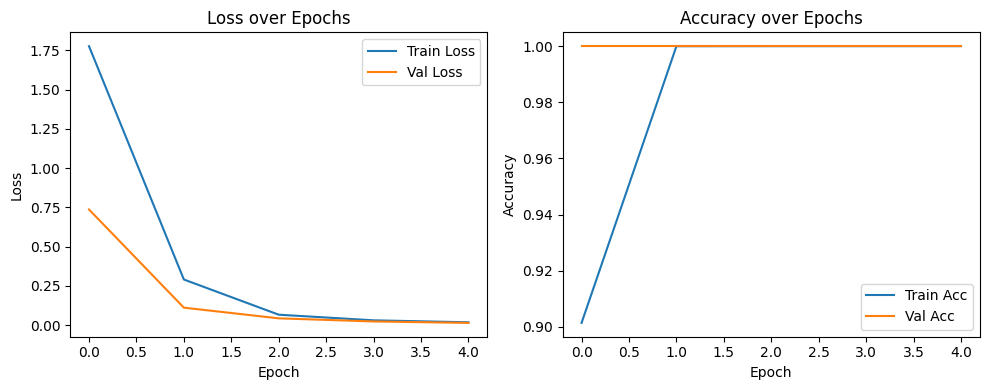

In [57]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [60]:
model.eval()
test_loss, test_acc = 0.0, 0.0
test_bar = tqdm(test_ldr, desc="Testing", leave=False)

for batch in test_bar:
    loss, acc = validate_batch(batch, model, UNetLoss)
    test_loss += loss
    test_acc += acc
    test_bar.set_postfix(loss=f"{loss:.4f}", acc=f"{acc:.4f}")

test_loss /= len(test_ldr)
test_acc /= len(test_ldr)
print(f"Test | Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

Test | Loss: 0.0143 | Acc: 1.0000
